In [4]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [ ]:
import json
import logging
import os
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import torch

from src.data.database_manager import DatabaseManager
from src.features.labels import add_labels
from src.features.resampling import add_normalized_timestamp
from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import (
    expand_feature_list,
    load_data_from_database,
    prepare_data,
)
from src.models.main_config import RANDOM_SEED
from src.models.utils import load_model
from src.plots.model_inference import (
    analyze_test_dataset_for_one_stimulus,
    plot_prediction_confidence_heatmap,
)
from src.plots.model_performance import (
    get_model_predictions,
    plot_multiple_pr_curves,
    plot_multiple_roc_curves,
    plot_single_roc_curve,
)
from src.plots.model_performance_per_participant import (
    analyze_per_participant,
    get_summary_statistics_single_model,
    plot_feature_accuracy_comparison,
    plot_participant_accuracy_comparison,
    plot_participant_performance_single_model,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "filelock"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials

polars.config.Config

In [18]:
feature_lists = [
    ["eda_raw", "pupil"],
    ["eda_raw", "heart_rate"],
    # ["eda_raw", "heart_rate", "pupil"],
    # ["face"],
    # ["eeg"],
]
feature_lists = expand_feature_list(feature_lists)
feature_list = feature_lists[0]
feature_list_str = "_".join(feature_list)

In [19]:
results = {}
winning_models = {}

for feature_list in feature_lists:
    feature_list_str = "_".join(feature_list)
    # Load data from database
    df = load_data_from_database(feature_list=[feature_list])

    # Load model
    json_path = Path(f"results/experiment_{feature_list_str}/results.json")
    dictionary = json.loads(json_path.read_text())
    model_path = Path(dictionary["overall_best"]["model_path"].replace("\\", "/"))

    model, feature_list, sample_duration_ms, intervals, label_mapping, offsets_ms = (
        load_model(model_path, device="cpu")
    )
    winning_models[feature_list_str] = {feature_list_str: model.__class__.__name__}

    # Prepare data
    X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test = (
        prepare_data(
            df=df,
            feature_list=feature_list,
            sample_duration_ms=sample_duration_ms,
            intervals=intervals,
            label_mapping=label_mapping,
            offsets_ms=offsets_ms,
            random_seed=RANDOM_SEED,
        )
    )
    test_groups = prepare_data(
        df=df,
        feature_list=feature_list,
        sample_duration_ms=sample_duration_ms,
        intervals=intervals,
        label_mapping=label_mapping,
        offsets_ms=offsets_ms,
        random_seed=RANDOM_SEED,
        only_return_test_groups=True,
    )
    _, test_loader = create_dataloaders(
        X_train_val, y_train_val, X_test, y_test, batch_size=64
    )
    probs, y_true = get_model_predictions(
        model,
        test_loader,
    )
    results[feature_list_str] = (probs, y_true)

14:40:35 | INFO    | utils | Using device: cpu
14:40:35 | INFO    | utils | Loaded PatchTST model with test accuracy 0.76 to cpu
14:40:35 | INFO    | utils | Input shape: (70, 2) | Features: ['eda_raw', 'pupil'] | Sample duration: 7000 ms
14:40:35 | DEBUG   | utils | Intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
14:40:35 | DEBUG   | utils | Label mapping: {'increases': 0, 'plateaus': 0, 'decreases': 1}
14:40:35 | DEBUG   | utils | Offset ms: {'increases': 0, 'plateaus': 5000, 'decreases': 1000}
14:40:35 | DEBUG   | sample_creation | Removed 749 samples with less than 69 data points
14:40:35 | DEBUG   | data_preparation | Preparing data with sample duration 7000 ms and random seed 42
14:40:35 | DEBUG   | data_preparation | Samples are based on intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
14:40:35 | DEBUG   | data

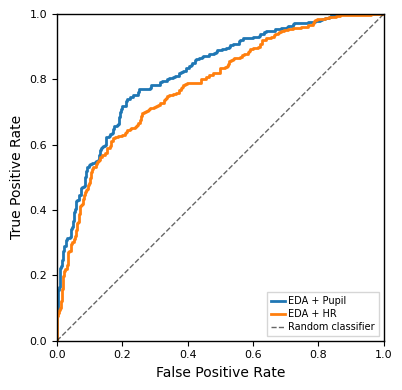

In [20]:
roc_curves = plot_multiple_roc_curves(results)


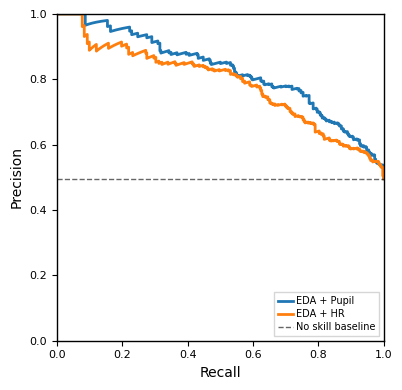

In [24]:
pr_curves = plot_multiple_pr_curves(results)


In [23]:
single_roc_curve = plot_single_roc_curve(results["eda_raw"][0], results["eda_raw"][1])

KeyError: 'eda_raw'

In [ ]:
probs, y_true = get_model_predictions(
    model,
    test_loader,
)

/Users/visser/drive/PhD/Code/pain-measurement/src/plots/model_performance.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  conf_matrix_plot.show()
/Users/visser/drive/PhD/Code/pain-measurement/src/plots/model_performance.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  conf_matrix_plot.show()


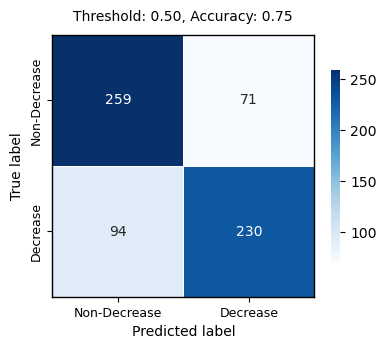

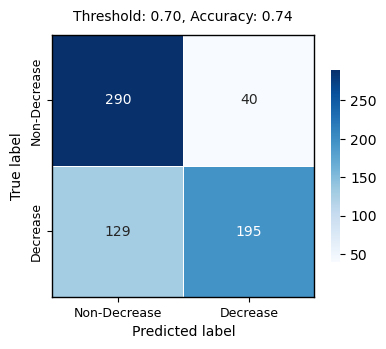

In [ ]:
conf_matrix_05 = get_confusion_matrix(probs, y_true, threshold=0.5)
conf_matrix_08 = get_confusion_matrix(probs, y_true, threshold=0.7)

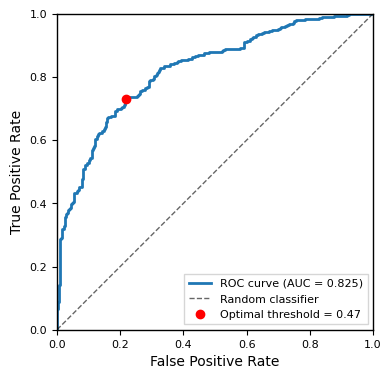

In [ ]:
single_roc_curve = plot_single_roc_curve(probs, y_true)

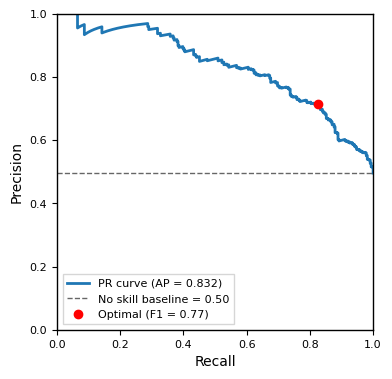

In [ ]:
single_pr_curve = plot_single_pr_curve(probs, y_true)  # ap = average precision